**Library Imports**

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.max_rows = 999

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import DBSCAN, KMeans

**Read in Data**

In [80]:
df_all = pd.read_csv('data/players_all.csv', index_col = 0)
df_2021 = pd.read_csv('data/players_2021.csv', index_col = 0)

In [81]:
df_all.head()

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,in_playoff
0,Steven Adams,OKC,2020,63,26.7,0.592,0.333,9.3,2.3,0.8,1.1,10.9,C,20.5,0.604,2.9,0.185,1
1,Bam Adebayo,MIA,2020,72,33.6,0.557,0.143,10.2,5.1,1.1,1.3,15.9,PF,20.3,0.598,3.4,0.168,1
2,LaMarcus Aldridge,SAS,2020,53,33.1,0.493,0.389,7.4,2.4,0.7,1.6,18.9,C,19.7,0.571,1.4,0.122,0
3,Kyle Alexander,MIA,2020,2,6.5,0.500,NaN,1.5,0.0,0.0,0.0,1.0,C,4.7,0.500,-9.6,-0.003,1
4,Nickeil Alexander-Walker,NOP,2020,47,12.6,0.368,0.346,1.8,1.9,0.4,0.2,5.7,SG,8.9,0.473,-4.6,-0.020,0


In [82]:
df_2021.head()

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage
0,Precious Achiuwa,MIA,2021,35,14.0,0.579,NaN,4.0,0.6,0.4,0.5,6.1,PF,15.4,0.587,-2.7,0.111
1,Jaylen Adams,MIL,2021,7,2.6,0.125,0.000,0.4,0.3,0.0,0.0,0.3,PG,-6.6,0.125,-19.8,-0.250
2,Steven Adams,NOP,2021,33,27.8,0.615,0.000,8.9,2.1,0.9,0.6,8.0,C,16.0,0.597,-0.9,0.110
3,Bam Adebayo,MIA,2021,33,33.9,0.563,0.333,9.5,5.4,0.9,1.0,19.2,C,22.0,0.631,4.4,0.193
4,LaMarcus Aldridge,SAS,2021,21,25.9,0.464,0.360,4.5,1.7,0.4,0.9,13.7,C,15.0,0.545,-1.2,0.074


Check for nulls in both dataframes. Nulls should be present since during the scrape we were left with blank cells for any data that was not provided. Luckily it will be able to universely replace these nulls since they will indicate a 0.0 data value: 

In [83]:
#checking for all players scrape:
df_all.isnull().sum()

name                        0
team                        0
year                        0
games_played                0
mpg                         0
fg%                        50
3pfg%                    2086
rebounds                    0
assists                     0
steals                      0
blocks                      0
points_per_game             0
position                    0
player_efficiency           3
true_shooting              45
plus_minus                  0
win_shares_percentage       3
in_playoff                  0
dtype: int64

In [84]:
#checking nulls for 2021 player scrape:
df_2021.isnull().sum()

name                      0
team                      0
year                      0
games_played              0
mpg                       0
fg%                       3
3pfg%                    29
rebounds                  0
assists                   0
steals                    0
blocks                    0
points_per_game           0
position                  0
player_efficiency         0
true_shooting             3
plus_minus                0
win_shares_percentage     0
dtype: int64

In [85]:
#fill nulls for both data frames:
df_all.fillna(0, inplace=True)
df_2021.fillna(0, inplace=True)

In [86]:
#checking for no nulls:
print(df_all.isnull().sum())
print(df_2021.isnull().sum())

name                     0
team                     0
year                     0
games_played             0
mpg                      0
fg%                      0
3pfg%                    0
rebounds                 0
assists                  0
steals                   0
blocks                   0
points_per_game          0
position                 0
player_efficiency        0
true_shooting            0
plus_minus               0
win_shares_percentage    0
in_playoff               0
dtype: int64
name                     0
team                     0
year                     0
games_played             0
mpg                      0
fg%                      0
3pfg%                    0
rebounds                 0
assists                  0
steals                   0
blocks                   0
points_per_game          0
position                 0
player_efficiency        0
true_shooting            0
plus_minus               0
win_shares_percentage    0
dtype: int64


Since we are trying to measure and compare different players and if they are playoff caliber, it is important to remember that players will be typically be playing different amount of minutes per game (measured by mpg). So it is important that we establish a tiered system for players, so that our model will be not be trying to determine how a player with far lesser stats who plays 20+ mpg is on a playoff team will the 30+ player with better stats all around does not make the playoffs. A tiered system will be allow us to more meaningul measure a players contributions while accounting for their "expectations" for their tiers from a playoff caliber standpoint. So let's first sort our current player database by team and mpg and see what the landscape looks like:  

In [87]:
df_2021.sort_values(['team', 'mpg'], ascending = [True, False])

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage
489,Trae Young,ATL,2021,34,34.8,0.430,0.378,4.2,9.4,0.9,0.2,26.4,PG,22.9,0.595,4.1,0.165
214,De'Andre Hunter,ATL,2021,18,32.2,0.514,0.366,5.4,2.2,0.9,0.5,17.2,SF,17.6,0.640,2.5,0.151
212,Kevin Huerter,ATL,2021,36,32.1,0.426,0.365,3.6,3.7,1.3,0.2,12.1,SG,11.9,0.541,-0.6,0.076
97,John Collins,ATL,2021,36,30.7,0.536,0.388,7.6,1.4,0.4,1.0,18.0,PF,19.4,0.625,1.5,0.157
83,Clint Capela,ATL,2021,32,29.7,0.589,0.000,14.2,0.9,0.8,2.2,14.7,C,24.1,0.593,2.4,0.188
384,Cam Reddish,ATL,2021,26,28.8,0.365,0.262,4.0,1.3,1.3,0.3,11.2,SF,9.2,0.488,-3.6,0.025
50,Bogdan Bogdanović,ATL,2021,11,22.6,0.385,0.343,3.5,2.2,0.4,0.2,9.4,SG,9.9,0.537,-2.2,0.043
151,Danilo Gallinari,ATL,2021,24,21.9,0.391,0.388,3.4,1.5,0.5,0.1,11.7,PF,13.7,0.582,-1.1,0.099
200,Solomon Hill,ATL,2021,36,19.1,0.356,0.318,2.3,0.9,0.7,0.2,4.3,PF,6.6,0.498,-3.0,0.032
422,Tony Snell,ATL,2021,23,18.3,0.482,0.565,2.0,1.2,0.1,0.3,5.1,SG,9.6,0.688,-0.7,0.083


**Setting Our Player Tiers:**

Most teams will typically play their best players around 30+ minutes per game with most team averaging 3-4 players in this range. Ideally these will be the heaviest contributing players so we will want to compare across the league how these players contribute in relation to their league counterparts and see if it results in a playoff appearance. We can call these the "major players" since they will be the ones who are most responsible for whether a team is able to make the playoffs (in most cases). The next tier we can create is for the core players who are players that play roughly 20-30 minutes per game, these players are still high contributors but usually contribute in different ways than a major player might. Similar to major players, we will want to compare core level players to core level players so we will create seperate tiers and evenetually models for this purpose. Next tier is for players who play 10-20 minutes a game, which we call rotational players. These are players that still important, and (along with core players) are what most analysts refer to as depth. Depth is an important element to a successful team because many teams will fall short despite having high quality stars (major players) but lackluster depth. You need a bench that will be able to perform at high levels when a star player is off the court. Last tier is for players who play under 10 mins a game, I imagine these players will be a bit harder to predict from a modeling standpoint, but can still add value to a team and provide occassional sparks off the bench on a given night. 

Filtering out our dataframes based on the mpg categories we established. This ensures that we are appropriately comparing players on their tiered system. As we have different expectations of degrees of contribution for different tiered players:

In [88]:
#set 2021 star/major contributors frame to 30+ mpg and more than 10 games:
major_players_2021=df_2021[(df_2021['mpg'] >= 30) & (df_2021['games_played'] >= 10)]

#set all players star/major contribotors frame to 30+ and more than 20 games:
major_players_all=df_all[(df_all['mpg'] >= 30) & (df_all['games_played'] >= 20)]

#set 2021 core players frame to 20-30 mpg and more than 10 games:
core_players_2021=df_2021[(df_2021['mpg'].between(20,29.9)) & (df_2021['games_played'] > 10)]

#set all players core players frame to 20-30 mpg and more than 20 games:
core_players_all=df_all[(df_all['mpg'].between(20,29.9)) & (df_all['games_played'] > 20)]

#set 2021 rotational players frame to 10-20 mpg and more than 10 games:
rotational_players_2021=df_2021[(df_2021['mpg'].between(10,19.9)) & (df_2021['games_played'] > 10)]

#set 2021 rotational players frame to 10-20 mpg and more than 10 games:
rotational_players_all=df_all[(df_all['mpg'].between(10,19.9)) & (df_all['games_played'] > 10)]

#set 2021 reserve players frame to under 10 mpg w/ no game restriction:
reserve_players_2021=df_2021[df_2021['mpg'] < 10]

#set all reserve players frame to under 10 mpg w/ no game restriction:
reserve_players_all=df_all[df_all['mpg'] < 10]

Save the data frames to their own csv for modeling purposes:

In [89]:
#save frames to csv for modeling:
major_players_2021.to_csv('data/major_players_2021.csv')
major_players_all.to_csv('data/major_players_all.csv')
core_players_2021.to_csv('data/core_players_2021.csv')
core_players_all.to_csv('data/core_players_all.csv')
rotational_players_2021.to_csv('data/rotational_players_2021.csv')
rotational_players_all.to_csv('data/rotational_players_all.csv')
reserve_players_2021.to_csv('data/reserve_players_2021.csv')
reserve_players_all.to_csv('data/reserve_players_all.csv')

Let's see if our tiers we created makes sense by running a histogram and a describe on our minutes per game metric for all of our players along with our 2021 player charts. Hopefully should looks pretty similar to ensure we are making sensible comparions:

### Histograms

count    13945.000000
mean        20.398745
std         10.168311
min          0.000000
25%         12.000000
50%         19.800000
75%         28.800000
max         43.700000
Name: mpg, dtype: float64
count    492.000000
mean      19.751423
std        9.794525
min        1.600000
25%       11.475000
50%       19.800000
75%       28.425000
max       37.800000
Name: mpg, dtype: float64


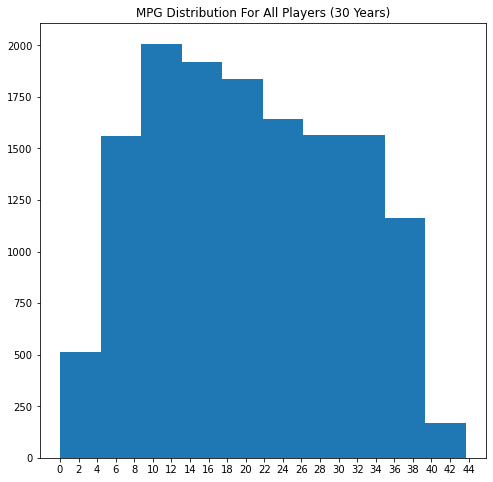

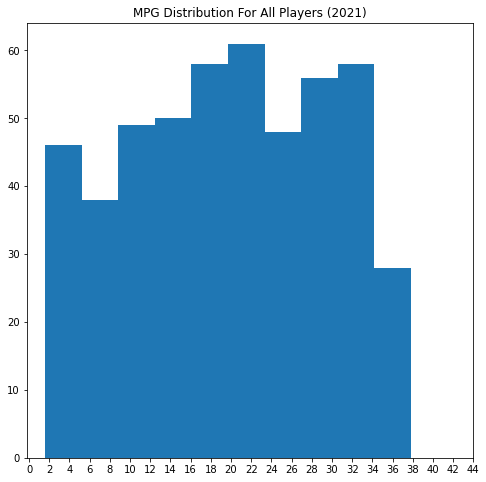

In [90]:
print(df_all.mpg.describe())
print(df_2021.mpg.describe())

plt.figure(figsize=(8, 8))
plt.hist(df_all.mpg)
plt.xticks(range(0,45,2))
plt.title('MPG Distribution For All Players (30 Years)')

plt.figure(figsize=(8, 8))
plt.hist(df_2021.mpg)
plt.xticks(range(0,45,2))
plt.title('MPG Distribution For All Players (2021)');

**Findings:** It looks like there are slightly different shapes in our two histograms which might lead us to believe that the stars/major players are playing on average less than the starts of previous eras. This would line up with the growing trend of what is known as "load management" which aims to better monitor the stress endured by playing higher minutes of the game on a player in hopes of better avoiding injury and keeping players fresh. This will be something to keep in mind when designing our model and considering if we want to incorprate era-restrictions to our various models. However we can see that our quartiles for both dataframes are within reason of the tiers we've created so we should be have a somewhat balanced class system from a data standpoint. 

### Heatmap Correlations

Let's now take a look at each tier and how our metrics correlate with our target variable (in_playoff). This should give us an idea of the which features should be the best indicators of whether a player is likely to contribute in specific ways or at a particular statisitcal rate that can help contribute to a playoff caliber team. While basketball is very much a team game, it's comprised of contributing individuals, so as we've been theorizing if all players across their tiers can contribute at a certain level, the team will succeed. 

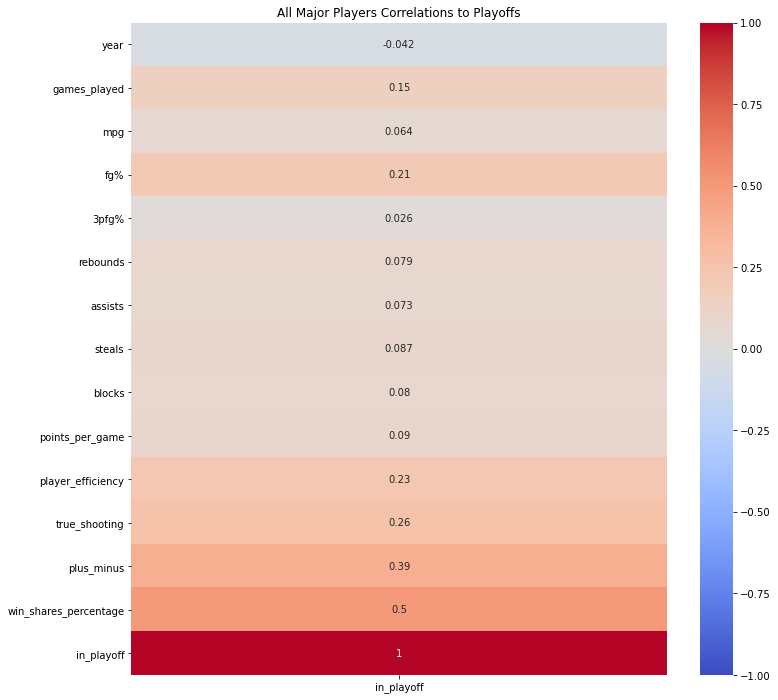

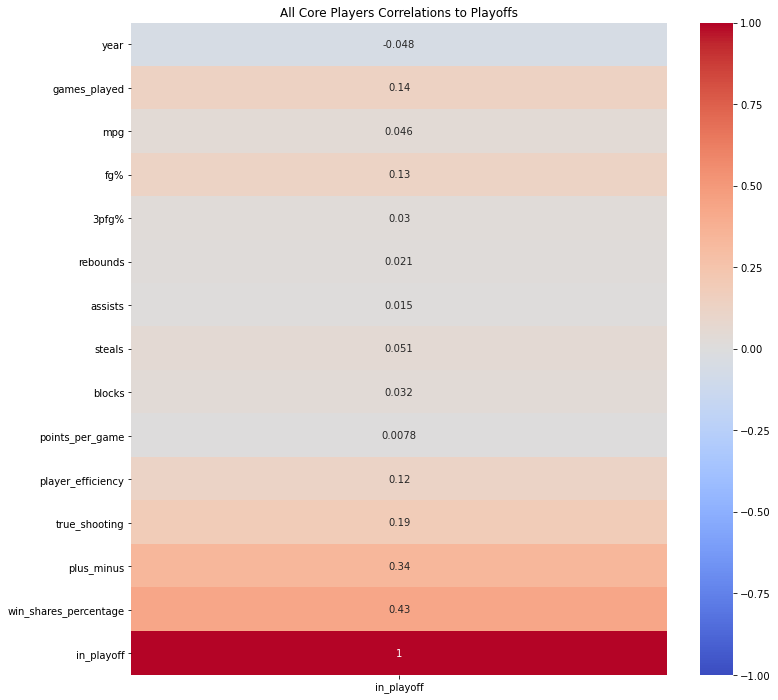

In [91]:
#Top 2 Tiers Major and Core Players:
plt.figure(figsize=(12, 12))
plt.title('All Major Players Correlations to Playoffs')
sns.heatmap(major_players_all.corr()[['in_playoff']],
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1),

plt.figure(figsize=(12, 12))
plt.title('All Core Players Correlations to Playoffs')
sns.heatmap(core_players_all.corr()[['in_playoff']],
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1);

**Findings:** Not all that surprisingly, across both tiers the correlations are similar in order but just different in magnitude. The prevailing features are win_shares, percentage, plus_minus, true_shooting, player_efficiency, followed by points_per_game. This would make sense since these mentioned metrics are known as advanced statistics and are usually compounds created that attempt to truly measure the individual player and their overall impact on the game by accounting for all the positives but as well the negatives. So intuitively, the more a player is able to contribute towards a winning effort, the more likely the team is to win. And if you have a team designed in ways that all tiers are contributing positively, the even greater chance the team will have towards being successful.

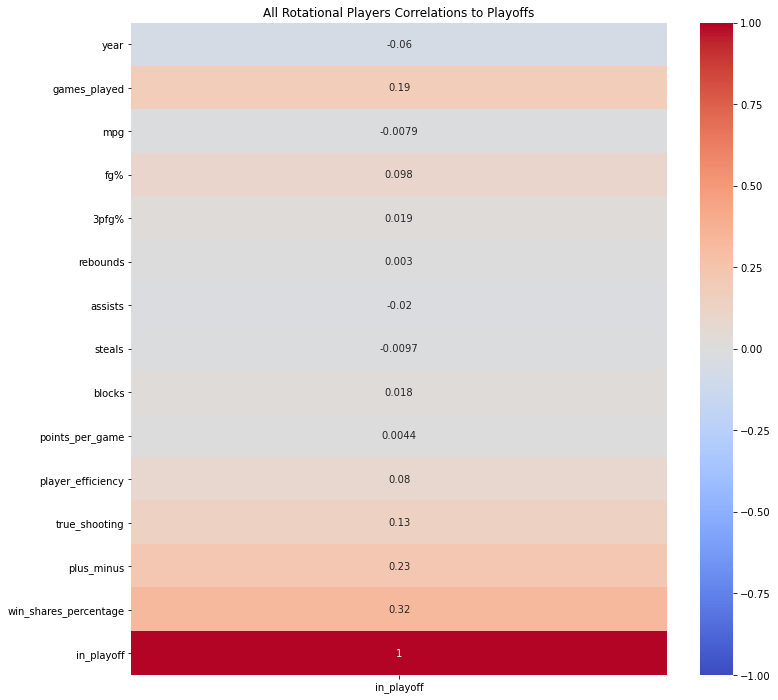

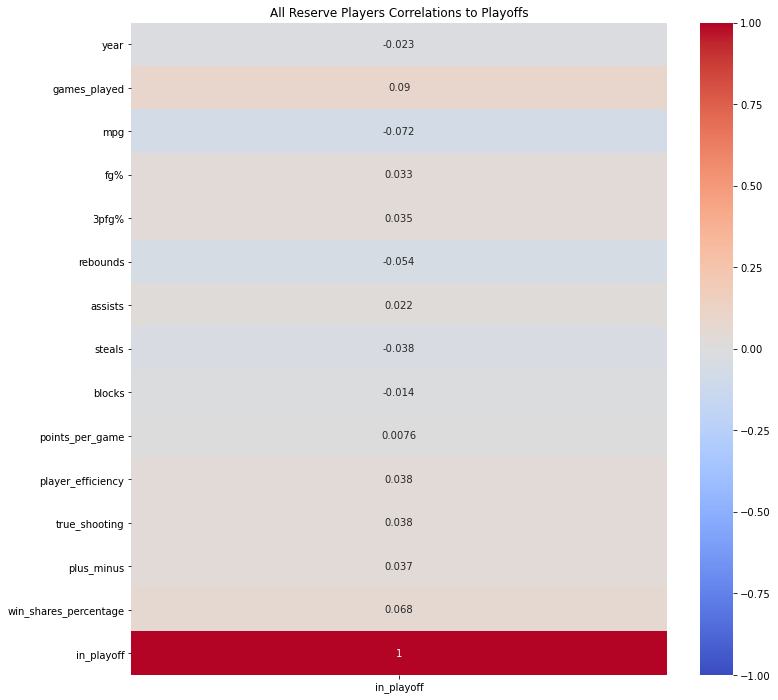

In [92]:
#Next 2 Tiers Rotational & Reserve:
plt.figure(figsize=(12, 12))
plt.title('All Rotational Players Correlations to Playoffs')
sns.heatmap(rotational_players_all.corr()[['in_playoff']],
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1)

plt.figure(figsize=(12, 12))
plt.title('All Reserve Players Correlations to Playoffs')
sns.heatmap(reserve_players_all.corr()[['in_playoff']],
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1);

**Findings:** Again we see consistent correlations with our 2 lower tiers. While this shows it may be harder to predict when modeling time comes, it can also give us insight that maybe players on a reserve level will be less of a necessary focus when assessing our Celtics team and be less important if they fall short of being "playoff caliber". Essentially these players producing at servicable levels may be more of a "nice to have" as opposed to "must haves" for a successful team. 

### Pairplots

Next let's look at pairplots with players labeled by whether they made the playoffs that season or not. We would like to see some groupings or trends that will provide us with support that we will be able to predict our target based on these statistics. Let's take a look based on the basic stat columns and then as well via the advanced stat columns:

In [93]:
df_all.head()

,name,team,year,games_played,mpg,fg%,3pfg%,rebounds,assists,steals,blocks,points_per_game,position,player_efficiency,true_shooting,plus_minus,win_shares_percentage,in_playoff
0,Steven Adams,OKC,2020,63,26.7,0.592,0.333,9.3,2.3,0.8,1.1,10.9,C,20.5,0.604,2.9,0.185,1
1,Bam Adebayo,MIA,2020,72,33.6,0.557,0.143,10.2,5.1,1.1,1.3,15.9,PF,20.3,0.598,3.4,0.168,1
2,LaMarcus Aldridge,SAS,2020,53,33.1,0.493,0.389,7.4,2.4,0.7,1.6,18.9,C,19.7,0.571,1.4,0.122,0
3,Kyle Alexander,MIA,2020,2,6.5,0.500,0.000,1.5,0.0,0.0,0.0,1.0,C,4.7,0.500,-9.6,-0.003,1
4,Nickeil Alexander-Walker,NOP,2020,47,12.6,0.368,0.346,1.8,1.9,0.4,0.2,5.7,SG,8.9,0.473,-4.6,-0.020,0


In [94]:
basic_features = ['fg%', '3pfg%', 'rebounds', 'assists', 'steals', 'blocks', 'points_per_game', 'in_playoff']
advanced_features = ['player_efficiency', 'true_shooting', 'plus_minus', 'win_shares_percentage' , 'in_playoff']

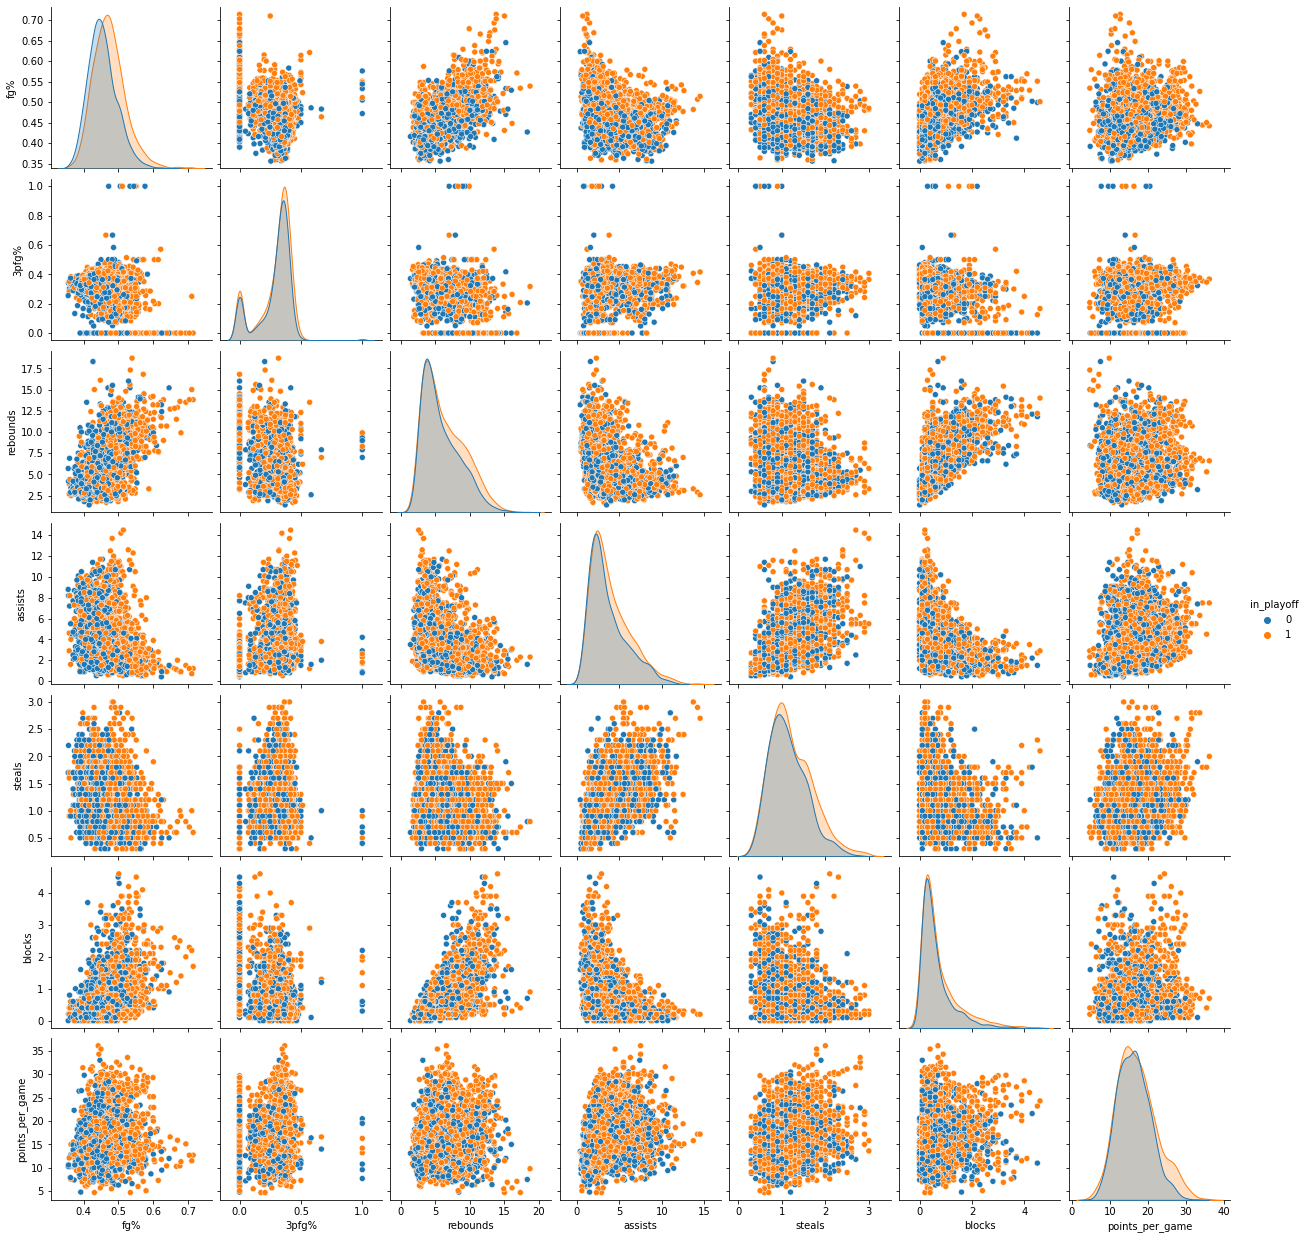

In [95]:
sns.pairplot(major_players_all[basic_features], hue = 'in_playoff');

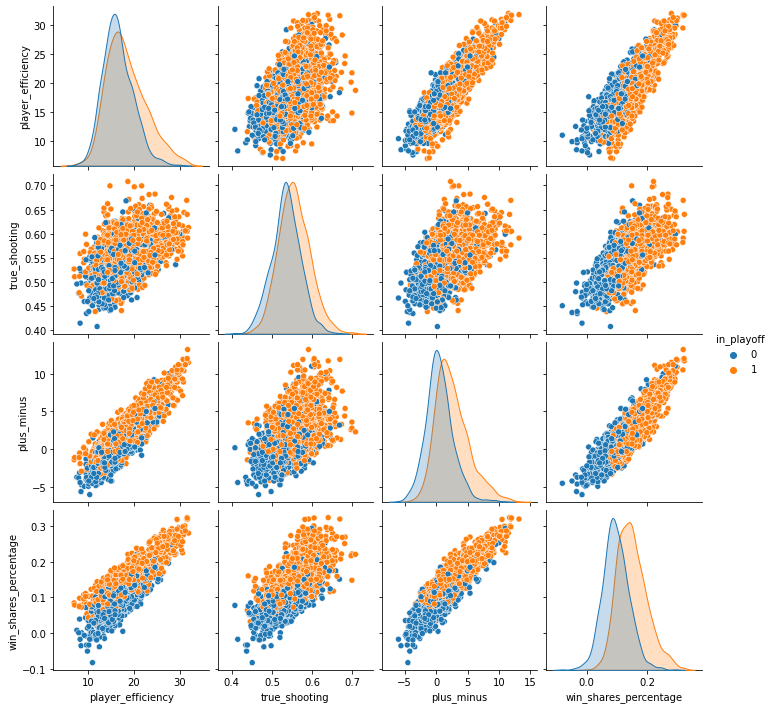

In [96]:
sns.pairplot(major_players_all[advanced_features], hue = 'in_playoff');

**Findings:** As to be expected based on our preceeding EDA, we can see that the advanced statistics cut provides much more of a defined clustering trend under the playoff hue labeling. While it's much less defined in the basics statistics, there does still seem to be somewhat of a pattern so would be worthwhile to keep the features if our processing powers permit. But evaluating both our heatmap and pairplots, we should be able to proceed with our modeling and build an classifier model than can provide enough accuracy to provide considerable value when analyzing our team and using our predictions to identify if a player is deemed "playoff caliber"

### KMeans Clustering

Another aspect of our data I wanted to explore relates to the different eras of the game. So often we hear analysts talk about the 90's, 00's and modern day era, so I decided to just use a KMeans clustering method based on the years which should result in a cluster corresponding to each decade era. We could just take the averages of each era by defining new decades based dataframes, but KMeans clustering by year will help us circumvent that and allow us to easily observe any trends across decades via pandas dfs. Using these clusters we should be able to see any changes in statistics that might reflect the changes in the overall game. If there is enough of a difference, it will certainly impact how we will want to approach our models to make sure we are contextualize our modern players correctly and not using outdated data that might not apply. 

In [97]:
features = df_all.drop(columns=['name', 'team', 'games_played','position', 'in_playoff'])

In [98]:
made_ploffs=df_all[df_all['in_playoff'] == 1]

In [99]:
major_year = major_players_all[['year']]
core_year = core_players_all[['year']]
rot_year = rotational_players_all[['year']]
reserve_players_all = reserve_players_all[['year']]

In [100]:
model_major = KMeans(n_clusters=3, random_state=42)
model_major.fit(major_year)

# Get the labels and centroids for our first clustering model
km_labels = model_major.labels_
centroids = model_major.cluster_centers_

major_players_all['labels'] = km_labels
major_players_all.labels.value_counts()

print(major_players_all.labels.value_counts())
major_players_all.groupby('labels').mean().sort_values('year').T

0    1118
2    1063
1     898
Name: labels, dtype: int64


<ipython-input-100-a1809123b2d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_players_all['labels'] = km_labels


labels,0,2,1
year,1995.017889,2005.635936,2015.368597
games_played,71.981216,72.460019,68.576837
mpg,34.900537,35.110536,33.401002
fg%,0.470748,0.458312,0.463898
3pfg%,0.257787,0.294197,0.319150
rebounds,6.229964,6.016839,5.948552
assists,3.838104,3.661430,3.936303
steals,1.259213,1.129633,1.134521
blocks,0.731485,0.675165,0.626392
points_per_game,16.435242,16.512700,17.187751


**Findings:** We can see from our clustering that over the 3 decades the game has evolved most noticeably from beyond the arc. This is shown by the steady increase in league averages of 3pfg%. The increased focused on 3pt shooting has been well publicized within the past 10 years, so it would make sense we observed the above trend. Most other metrics have remained relatively constant over the 3 decades which means we should still be able to use all 30 years of data for our model, but will be interesting to apply possibly a decades based solution during modeling. 

The above clustering only applies to league averages, so let's also see if there's any notable changes over the 3 decades for teams that made the playoff. Maybe we can gleam from these clustered observations something valuable that will help us in our overall analysis

In [101]:
major_ploffs = major_players_all[major_players_all['in_playoff']==1]
major_playoffs_year=major_ploffs[['year']]

model_major_2 = KMeans(n_clusters=3, random_state=42)
model_major_2.fit(major_playoffs_year)

# Get the labels and centroids for our first clustering model
km_labels_2 = model_major_2.labels_
centroids = model_major_2.cluster_centers_

major_ploffs['labels'] = km_labels_2
major_ploffs.labels.value_counts()

print(major_ploffs.labels.value_counts())
major_ploffs.groupby('labels').mean().sort_values('year').T

2    580
0    547
1    525
Name: labels, dtype: int64


<ipython-input-101-c13c066584b8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_ploffs['labels'] = km_labels_2


labels,2,0,1
year,1994.462069,2004.438757,2014.958095
games_played,73.074138,74.341865,71.215238
mpg,35.020862,35.281901,33.762286
fg%,0.482962,0.462371,0.474617
3pfg%,0.261128,0.293892,0.322697
rebounds,6.496034,6.137294,6.198095
assists,3.942759,3.823949,4.122857
steals,1.298621,1.170567,1.170667
blocks,0.786552,0.726874,0.677524
points_per_game,16.729655,16.789031,17.787619


**Findings:** Consistent with our league averages, we also see a trend of increased focus on 3 point shooting. We also see an increase in player efficiency, which might lead us to speculate that this trend coupled with the 3 point shooting trend means that heightened efficiency has become the defining characteristic of a playoff caliber player in today's era. Something to keep in mind when making our recommendations and analysis. 

Let's do the same with our core players and see if there's any notable

In [102]:
model_core = KMeans(n_clusters=3, random_state=42)
model_core.fit(core_year)

# Get the labels and centroids for our first clustering model
km_labels = model_core.labels_
centroids = model_core.cluster_centers_

core_players_all['labels'] = km_labels
core_players_all.labels.value_counts()

print(core_players_all.labels.value_counts())
core_players_all.groupby('labels').mean().sort_values('year').T

2    1427
0    1232
1     968
Name: labels, dtype: int64


<ipython-input-102-3df6e499e3ed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_players_all['labels'] = km_labels


labels,1,0,2
year,1994.677686,2004.998377,2015.627190
games_played,67.424587,68.939935,65.474422
mpg,24.832541,24.711120,24.905256
fg%,0.461450,0.450644,0.453497
3pfg%,0.228361,0.248701,0.296677
rebounds,4.228719,4.261120,4.388437
assists,2.193388,2.005114,2.124247
steals,0.828822,0.761201,0.771549
blocks,0.522417,0.501705,0.498248
points_per_game,9.648037,8.916721,9.967554


**Findings:** Again pretty similar to the trend observed with our major players. Definitely a steady increase in 3pt percentage. Outside of that the averages seem to remain pretty consistent, so we could maybe theorize the roll of a core player has changed that drastically over the years. Let's see if there's anything that jumps out when we just look at "playoff caliber" core players over the years

In [103]:
core_ploffs = core_players_all[core_players_all['in_playoff']==1]
core_playoffs_year=core_ploffs[['year']]

model_core_2 = KMeans(n_clusters=3, random_state=42)
model_core_2.fit(core_playoffs_year)

# Get the labels and centroids for our first clustering model
km_labels_3 = model_core_2.labels_
centroids = model_core_2.cluster_centers_

core_ploffs['labels'] = km_labels_3
core_ploffs.labels.value_counts()

print(core_ploffs.labels.value_counts())
core_ploffs.groupby('labels').mean().sort_values('year').T

2    612
1    523
0    496
Name: labels, dtype: int64


<ipython-input-103-2d7ba2b07844>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_ploffs['labels'] = km_labels_3


labels,1,0,2
year,1995.143403,2005.479839,2015.575163
games_played,69.915870,71.370968,67.326797
mpg,24.932505,24.849395,25.090196
fg%,0.467962,0.458798,0.460340
3pfg%,0.247229,0.246292,0.301954
rebounds,4.210899,4.391935,4.433333
assists,2.326769,1.949395,2.098039
steals,0.832505,0.776008,0.794771
blocks,0.509369,0.540927,0.521569
points_per_game,9.678967,8.956653,9.920261


**Findings:** Again no surprises, but it is important to note that the jump from the 2000s decade to the 2010s in playoff caliber players sees a more drastic increase in the 3pfg%, so during our analysis we will want to leverage these findings and be cognizant of any core players that might be showing above average shooting abilities from beyond the arc.  

#### EDA Summary

Based on the above EDA and KMeans modeling, I feel confident we should be able to help answer the problem statement through machine learning. We should be able to classify whether a player is performing at a playoff caliber level based on the previous 30 years of player data. By establishing tiers and contextualizing our players comparitively, we should be able to identify players who are poised to either lead or contribute to their teams in ways that will result in a playoff bid.